In [4]:
import pandas as pd
import numpy as np
import random as rand
import os
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

In [3]:
data = pd.read_csv('MFGEmployees4.csv')
df = data.copy()
df.tail()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
8331,8332,Coniglio,Bianca,F,Langley,Cashier,Customer Service,Langley,Stores,46.057544,4.838288,93.665111,Stores
8332,8333,Cox,Jimmie,M,Montney,Cashier,Customer Service,Fort St John,Stores,34.455490,2.427274,0.000000,Stores
8333,8334,Hawkins,Mary,F,West Vancouver,Cashier,Customer Service,West Vancouver,Stores,58.347160,4.009393,176.356940,Stores
8334,8335,Proctor,Theresa,F,Vancouver,Dairy Person,Dairy,Vancouver,Stores,43.340616,6.154837,60.321917,Stores
8335,8336,Salter,Charles,M,Vancouver,Dairy Person,Dairy,Vancouver,Stores,46.192782,5.174722,112.023389,Stores


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EmployeeNumber  8336 non-null   int64  
 1   Surname         8336 non-null   object 
 2   GivenName       8336 non-null   object 
 3   Gender          8336 non-null   object 
 4   City            8336 non-null   object 
 5   JobTitle        8336 non-null   object 
 6   DepartmentName  8336 non-null   object 
 7   StoreLocation   8336 non-null   object 
 8   Division        8336 non-null   object 
 9   Age             8336 non-null   float64
 10  LengthService   8336 non-null   float64
 11  AbsentHours     8336 non-null   float64
 12  BusinessUnit    8336 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 846.8+ KB


In [31]:
num_samples = 20000- df.shape[0]

In [72]:
sampled_data = df.sample(num_samples,replace = True).reset_index(drop = True)

In [73]:
#Adding slight noise to numerical columns
sampled_data['AbsentHours'] = sampled_data['AbsentHours'] + np.random.normal(0, 1, size=num_samples)
sampled_data['Age'] = sampled_data['Age'] + np.random.normal(0, 1, size=num_samples)
sampled_data['LengthService'] = sampled_data['LengthService'] + np.random.normal(0, 1, size=num_samples)

In [74]:
df_new = pd.concat([df,sampled_data], ignore_index=True)

In [75]:
print(f'negative values in AbsentHours:- {df_new[df_new["AbsentHours"]<0].AbsentHours.count()}')
print(f'negative values in Age:- {df_new[df_new["Age"]<0].Age.count()}')
print(f'negative values in LengthService:- {df_new[df_new["LengthService"]<0].LengthService.count()}')


negative values in AbsentHours:- 925
negative values in Age:- 0
negative values in LengthService:- 51


In [76]:
#Eliminating negative values
df_new['AbsentHours']= df_new['AbsentHours'].clip(lower = 0)
df_new['Age']= df_new['Age'].clip(lower = 0)
df_new['LengthService']= df_new['LengthService'].clip(lower = 0)


In [77]:
print(f'negative values in AbsentHours:- {df_new[df_new["AbsentHours"]<0].AbsentHours.count()}')
print(f'negative values in Age:- {df_new[df_new["Age"]<0].Age.count()}')
print(f'negative values in LengthService:- {df_new[df_new["LengthService"]<0].LengthService.count()}')

negative values in AbsentHours:- 0
negative values in Age:- 0
negative values in LengthService:- 0


In [78]:
df_new.head()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [79]:
df_new.tail()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
19995,6158,Beene,Jason,M,Terrace,Cashier,Customer Service,Terrace,Stores,43.141803,2.681158,36.313526,Stores
19996,6667,Morgan,Brooke,F,Squamish,Shelf Stocker,Processed Foods,Squamish,Stores,58.662683,4.861219,189.124627,Stores
19997,2627,Parker,Ruby,F,New Westminster,Meat Cutter,Meats,New Westminster,Stores,44.867022,5.148219,87.390246,Stores
19998,4227,McCullough,Sallie,F,Vancouver,Baker,Bakery,Vancouver,Stores,32.737157,2.477647,52.960432,Stores
19999,823,Bowman,Ramon,M,Telegraph Creek,Cashier,Customer Service,Terrace,Stores,44.247865,5.654959,89.565500,Stores


In [80]:
print(df.EmployeeNumber.value_counts().sort_index().index)

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       8327, 8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336],
      dtype='int64', name='EmployeeNumber', length=8336)


In [81]:
df_new.EmployeeNumber.value_counts().sort_index().index #Duplicate values

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       8327, 8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336],
      dtype='int64', name='EmployeeNumber', length=8336)

In [82]:
max_id_lower = df_new.EmployeeNumber.max()
max_id_lower

8336

In [83]:
20000-8336

11664

In [88]:
list(df_new.EmployeeNumber)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [87]:
new_id = [x for x in range(max_id+1, len(df_new)+1)]
new_id[-1]

20000

In [89]:
df_new.EmployeeNumber = list(df.EmployeeNumber) + new_id

In [91]:
df_new.EmployeeNumber.value_counts().sort_index()

EmployeeNumber
1        1
2        1
3        1
4        1
5        1
        ..
19996    1
19997    1
19998    1
19999    1
20000    1
Name: count, Length: 20000, dtype: int64

In [92]:
df_new.head()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [27]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28336 entries, 0 to 28335
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EmployeeNumber  28336 non-null  int64  
 1   Surname         28336 non-null  object 
 2   GivenName       28336 non-null  object 
 3   Gender          28336 non-null  object 
 4   City            28336 non-null  object 
 5   JobTitle        28336 non-null  object 
 6   DepartmentName  28336 non-null  object 
 7   StoreLocation   28336 non-null  object 
 8   Division        28336 non-null  object 
 9   Age             28336 non-null  float64
 10  LengthService   28336 non-null  float64
 11  AbsentHours     28336 non-null  float64
 12  BusinessUnit    28336 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 2.8+ MB


In [95]:
df_new.iloc[8331:8336,:]

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
8331,8332,Coniglio,Bianca,F,Langley,Cashier,Customer Service,Langley,Stores,46.057544,4.838288,93.665111,Stores
8332,8333,Cox,Jimmie,M,Montney,Cashier,Customer Service,Fort St John,Stores,34.455490,2.427274,0.000000,Stores
8333,8334,Hawkins,Mary,F,West Vancouver,Cashier,Customer Service,West Vancouver,Stores,58.347160,4.009393,176.356940,Stores
8334,8335,Proctor,Theresa,F,Vancouver,Dairy Person,Dairy,Vancouver,Stores,43.340616,6.154837,60.321917,Stores
8335,8336,Salter,Charles,M,Vancouver,Dairy Person,Dairy,Vancouver,Stores,46.192782,5.174722,112.023389,Stores


In [96]:
df.tail()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
8331,8332,Coniglio,Bianca,F,Langley,Cashier,Customer Service,Langley,Stores,46.057544,4.838288,93.665111,Stores
8332,8333,Cox,Jimmie,M,Montney,Cashier,Customer Service,Fort St John,Stores,34.455490,2.427274,0.000000,Stores
8333,8334,Hawkins,Mary,F,West Vancouver,Cashier,Customer Service,West Vancouver,Stores,58.347160,4.009393,176.356940,Stores
8334,8335,Proctor,Theresa,F,Vancouver,Dairy Person,Dairy,Vancouver,Stores,43.340616,6.154837,60.321917,Stores
8335,8336,Salter,Charles,M,Vancouver,Dairy Person,Dairy,Vancouver,Stores,46.192782,5.174722,112.023389,Stores


Gender
M    4216
F    4120
Name: count, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

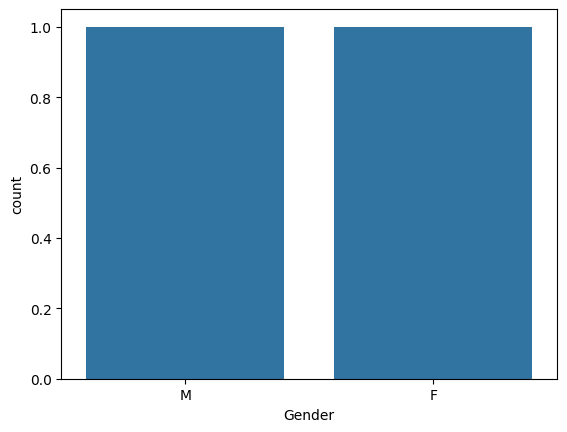

In [102]:
print(df.Gender.value_counts())
sb.countplot(df.Gender.value_counts())

Gender
M    10169
F     9831
Name: count, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

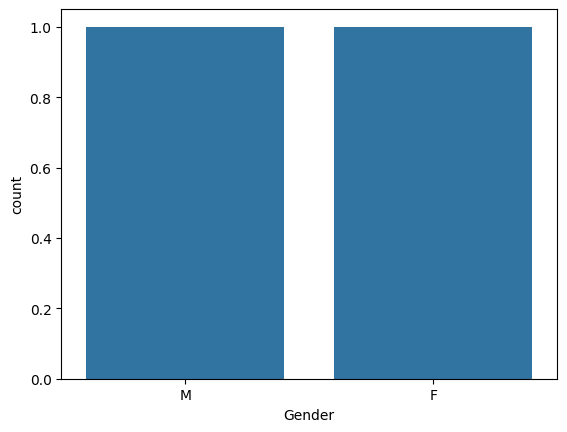

In [103]:
print(df_new.Gender.value_counts())
sb.countplot(df_new.Gender.value_counts())

In [97]:
df_new.to_csv('new_data1.csv', index = False)

In [98]:
df.EmployeeNumber.value_counts()

EmployeeNumber
1       1
5569    1
5567    1
5566    1
5565    1
       ..
2774    1
2773    1
2772    1
2771    1
8336    1
Name: count, Length: 8336, dtype: int64

In [9]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)
metadata.set_primary_key('EmployeeNumber')

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sdv\metadata\single_table.py:745: UserWarning: There is an existing primary key 'EmployeeNumber'. This key will be removed.
  warnings.warn(


In [10]:
synthesizer = GaussianCopulaSynthesizer(metadata)


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sdv\single_table\base.py:120: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
